In [2]:
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import optuna
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
raw_dataset = pd.read_csv("dataset.csv")

In [4]:
raw_dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
raw_dataset.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
raw_dataset = raw_dataset.drop_duplicates()

In [7]:
raw_dataset = raw_dataset.drop(["customerID"],axis=1)

In [8]:
# Drop empty value rows from dataset
value = ' '
raw_dataset = raw_dataset[raw_dataset["TotalCharges"]!= value]
# Type conversion for string values
raw_dataset["TotalCharges"] = raw_dataset["TotalCharges"].astype("float64")
raw_dataset = raw_dataset.reset_index()

In [9]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             7032 non-null   int64  
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [10]:
# Columns names including Yes , No Values
yes_no_columns = ["Partner","Dependents","PhoneService","PaperlessBilling","Churn"]
# Encode the values to  Yes=1 and No=0 
for column in yes_no_columns:
    raw_dataset[column] = raw_dataset[column].map(dict(Yes=1, No=0))	
# Binary encoding for gender column
raw_dataset["gender"] = raw_dataset["gender"].map(dict(Female=1, Male=0))	
# Check the column datatype and unique values
print("Number Of Unique Values",end="\n\n")
for key in raw_dataset:
    print(f"{key}: ",raw_dataset[f"{key}"].nunique(dropna=True) ,raw_dataset[f"{key}"].dtype)

Number Of Unique Values

index:  7032 int64
gender:  2 int64
SeniorCitizen:  2 int64
Partner:  2 int64
Dependents:  2 int64
tenure:  72 int64
PhoneService:  2 int64
MultipleLines:  3 object
InternetService:  3 object
OnlineSecurity:  3 object
OnlineBackup:  3 object
DeviceProtection:  3 object
TechSupport:  3 object
StreamingTV:  3 object
StreamingMovies:  3 object
Contract:  3 object
PaperlessBilling:  2 int64
PaymentMethod:  4 object
MonthlyCharges:  1584 float64
TotalCharges:  6530 float64
Churn:  2 int64


In [11]:
categorical_columns = raw_dataset.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [12]:
# Each Unique Value in categorical columns
for column in categorical_columns:
    print(column, raw_dataset[column].unique())

MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [13]:
# Initialize Encoder
encoder = OneHotEncoder(sparse_output=False)

In [14]:
# Encode categorical values
one_hot_encoded = encoder.fit_transform(raw_dataset[categorical_columns])
# Create a dataframe of encoded values
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
# Combine those dataframes
df_encoded = pd.concat([raw_dataset, one_hot_df], axis=1)
# Drop Categorical columns from raw_dataset
df_encoded = df_encoded.drop(categorical_columns, axis=1).drop("index",axis=1)

In [15]:
df_encoded

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,1,29.85,29.85,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,0,34,1,0,56.95,1889.50,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,0,0,0,2,1,1,53.85,108.15,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,0,0,45,0,0,42.30,1840.75,0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1,0,0,0,2,1,1,70.70,151.65,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,0,1,1,24,1,1,84.80,1990.50,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7028,1,0,1,1,72,1,1,103.20,7362.90,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7029,1,0,1,1,11,0,1,29.60,346.45,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7030,0,1,1,0,4,1,1,74.40,306.60,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
df_encoded.to_csv("Processed_dataset.csv",index=False)
dataset = pd.read_csv("Processed_dataset.csv")

### t-SNE: Dimensionality Reduction

t-SNE is a data visualization technique used to reduce the dimensionality of high dimensional datasets to lower dimensions, generally 2D or 3D. t-SNE saves the relationship between data points with decreasing the complexity. In this project, to perform K-Means Algorithm, t-SNE is used priorly to decrease the dimensionality of data.

In [17]:
projection = TSNE(n_components=2).fit_transform(dataset)

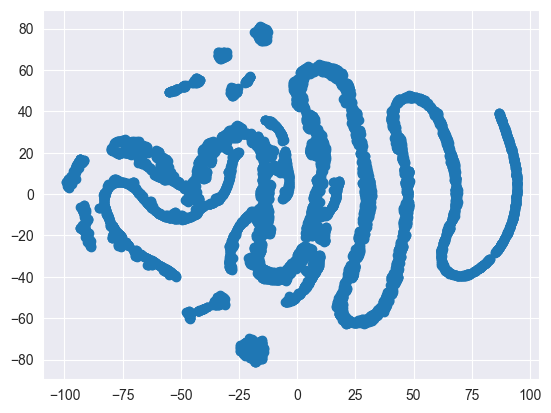

In [18]:
plt.scatter(projection[:,0], projection[:,1])

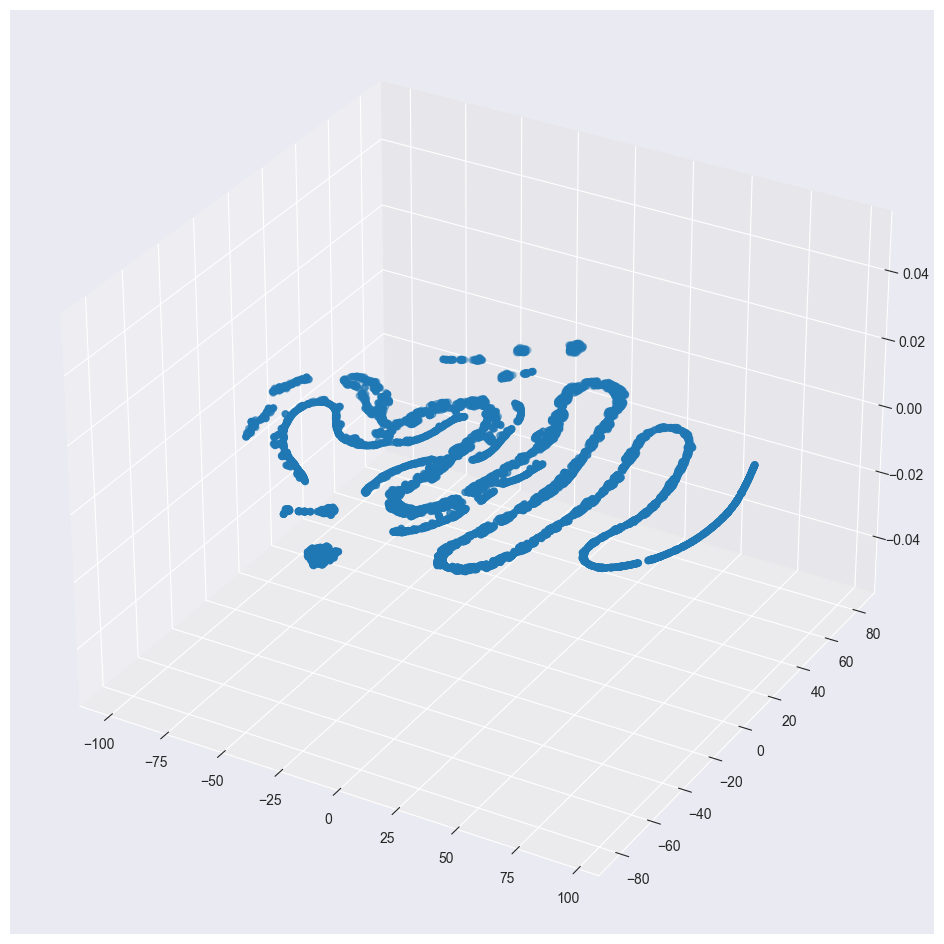

In [19]:
#to convert 2D shape to 3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(projection[:,0], projection[:,1])
plt.show()

### K-MEANS Clustering

K-Means is unsupervised machine learning algorithm to cluster data. It is used to partition a dataset into K distinct, non-overlapping clusters, where each data point belongs to the cluster with the nearest mean called centroid. The algorithm iteratively assigns data points to the nearest centroid and updates the centroids based on the mean of the data points assigned to each cluster until convergence.

In [20]:
n_clusters = 10

# Initialize K-means
kmeans = KMeans(n_clusters=n_clusters, n_init=20)

# Fit K-means to the data
kmeans.fit(dataset)

# Get cluster labels
labels = kmeans.labels_

<Axes: >

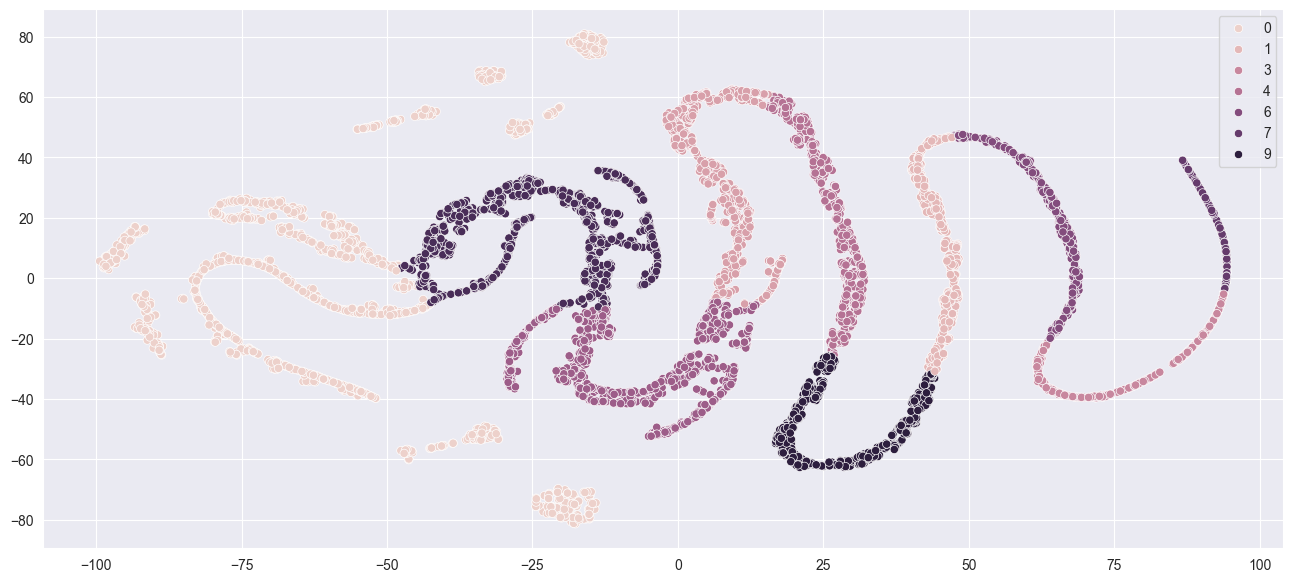

In [21]:
# to visualize the clustering results obtained by K-Means Algorithm
plt.figure(figsize=(16,7)),
sns.scatterplot(x=projection[:,0],y=projection[:,1],hue=labels)

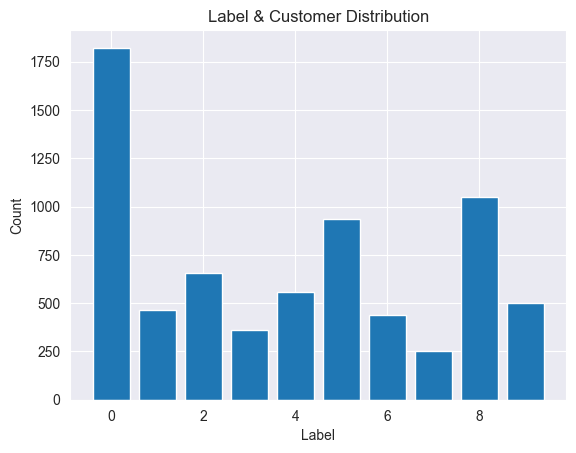

In [22]:
labels, counts = np.unique(kmeans.labels_, return_counts = True)
x = labels
y = counts

plt.bar(x,y)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label & Customer Distribution')
plt.show()

## Current Best hyperparameters: {'n_clusters': 4, 'n_init': 11, 'init': 'random'}

In [23]:
def objective(trial):
    # Define hyperparameters to optimize
    n_clusters = trial.suggest_int('n_clusters', 4, 20)
    n_initvalue = trial.suggest_int('n_init', 10, 50)
    n_init = trial.suggest_categorical('init', ['k-means++', 'random'])

    # Apply Agglomerative Clustering with the suggested hyperparameters
    model = KMeans(n_clusters=n_clusters, n_init=n_initvalue, init=n_init)
    clusters = model.fit_predict(dataset)
    
    # Evaluate clustering performance using silhouette score
    silhouette_avg = silhouette_score(dataset, clusters)
    return silhouette_avg

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-04-21 22:49:10,137] A new study created in memory with name: no-name-7957898d-478a-45f0-ad40-284550c759dc
[W 2024-04-21 22:49:10,606] Trial 0 failed with parameters: {'n_clusters': 11, 'n_init': 20, 'init': 'random'} because of the following error: NameError("name 'silhouette_score' is not defined").
Traceback (most recent call last):
  File "C:\Users\smfar\PycharmProjects\Customer\.venv\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\smfar\AppData\Local\Temp\ipykernel_7372\865891624.py", line 12, in objective
    silhouette_avg = silhouette_score(dataset, clusters)
                     ^^^^^^^^^^^^^^^^
NameError: name 'silhouette_score' is not defined
[W 2024-04-21 22:49:10,623] Trial 0 failed with value None.


NameError: name 'silhouette_score' is not defined

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn import metrics
kmeans_labels=KMeans(n_clusters=4, n_init=11, init='random').fit_predict(dataset)     
print("Silhouette score for {} clusters k-means : {} ".format(4,metrics.silhouette_score(dataset,kmeans_labels, metric='euclidean').round(3)))
print('Davies Bouldin Score:'+str(metrics.davies_bouldin_score(dataset,kmeans_labels).round(3)))

In [ ]:
for i in range(4,15):                
    kmeans_labels=KMeans(n_clusters=i, n_init=20).fit_predict(dataset)     
    print("Silhouette score for {} clusters k-means : {} ".format(i,metrics.silhouette_score(dataset,kmeans_labels, metric='euclidean').round(3)))
    print('Davies Bouldin Score:'+str(metrics.davies_bouldin_score(dataset,kmeans_labels).round(3)))

In [ ]:
cluster_sizes = list(range(4,16))
for i in cluster_sizes:
    kmeans = KMeans(n_clusters=i, n_init=20)
    kmeans.fit(dataset)
    labels = kmeans.labels_
    
    # Create a new figure for the scatter plot
    plt.figure(figsize=(16,7))
    plt.title(f"Clusters: {i}")
    sns.scatterplot(x=projection[:,0],y=projection[:,1],hue=labels)
    plt.show()  # Display the scatter plot
    
    # Create a new figure for the bar plot
    plt.figure(figsize=(10,5))
    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    x = labels
    y = counts
    plt.bar(x, y)
    plt.xlabel(f"Label: {i}")
    plt.ylabel('Count')
    plt.title('Label & Customer Distribution')
    plt.show()  # Display the bar plot


### Centroids

Centroids play a crucial role in K-means clustering algorithm by defining the center points of clusters and guiding the assignment of data points to their respective clusters.

In [ ]:
# Create a DataFrame for centroids
centroids_df = pd.DataFrame({'x': centroids[:, 0], 'y': centroids[:, 1]})

# Plot the centroids using seaborn
sns.scatterplot(x='x', y='y', data=centroids_df, marker='x', s=100, color='red', label='Centroids')

# Show the plot
plt.show()

### Optimization of K-Means Algorithm

#### 1) Initialization Methods: K-means++

K-means++ is an initialization method for the K-means algorithm that aims to improve the quality of the initial centroids. Compared to randomly initializing centroids, K-means++ selects initial centroids that are more spread out and likely to be closer to the final optimal solution.

In [ ]:
n_clusters = 10

# Initialize K-means
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=25)

# Fit K-means to the data
kmeans.fit(dataset)

# Get cluster labels
labels = kmeans.labels_

# to visualize the clustering results obtained by K-Means Algorithm
plt.figure(figsize=(16,7)),
sns.scatterplot(x=projection[:,0],y=projection[:,1],hue=labels)

#### 2) Convergence Criteria

Convergence criteria is used to detect the point where to stop iteration. The following code shows how to monitor the change in centroid positions between iterations and stop iterating when the change falls below a certain threshold.

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Define convergence threshold
tolerance = 1e-4  # You can adjust this threshold based on your requirement

# Initialize KMeans object
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10)

# Fit the K-means model to the data
kmeans.fit(dataset)

# Initialize centroids to track changes
previous_centroids = kmeans.cluster_centers_.copy()

# Iterate until convergence
while True:
    # Perform one iteration of K-means algorithm
    kmeans.fit(dataset)
    
    # Check convergence criterion: change in centroids
    centroid_change = np.linalg.norm(kmeans.cluster_centers_ - previous_centroids)
    if centroid_change < tolerance:
        break  # Stop iterating if convergence criterion is met
    
    # Update centroids for next iteration
    previous_centroids = kmeans.cluster_centers_.copy()

# Get the final cluster centroids and labels
final_centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# to visualize the clustering results obtained by K-Means Algorithm
plt.figure(figsize=(16,7)),
sns.scatterplot(x=projection[:,0],y=projection[:,1],hue=labels)
